# Assignment 1: Multi-Layer Perceptron with MNIST Dataset

In this assignment, you are required to train two MLPs to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database by using PyTorch.

The process will be broken down into the following steps:
1. Load and visualize the data.
2. Define a neural network. (30 marks)
3. Train the models. (30 marks)
4. Evaluate the performance of our trained models on the test dataset. (20 marks)
5. Analysis your results. (20 marks)

In [6]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

---
## Load and Visualize the Data

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [7]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
def classify_label(dataset, num_classes):
    list_index = [[] for _ in range(num_classes)]
    for idx, datum in enumerate(dataset):
        list_index[datum[1]].append(idx)
    return list_index

def partition_train(list_label2indices: list, num_per_class: int):
    random_state = np.random.RandomState(0)
    list_label2indices_train = []
    for indices in list_label2indices:
        random_state.shuffle(indices)
        list_label2indices_train.extend(indices[:num_per_class])
    return list_label2indices_train

class Indices2Dataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indices = None

    def load(self, indices: list):
        self.indices = indices

    def __getitem__(self, idx):
        idx = self.indices[idx]
        image, label = self.dataset[idx]
        return image, label

    def __len__(self):
        return len(self.indices)

#  sort train data by label
list_label2indices = classify_label(dataset=train_data, num_classes=10)
# how many samples per class to train
list_train = partition_train(list_label2indices, 500)

# prepare data loaders  
indices2data = Indices2Dataset(train_data)
indices2data.load(list_train)
train_loader = torch.utils.data.DataLoader(indices2data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

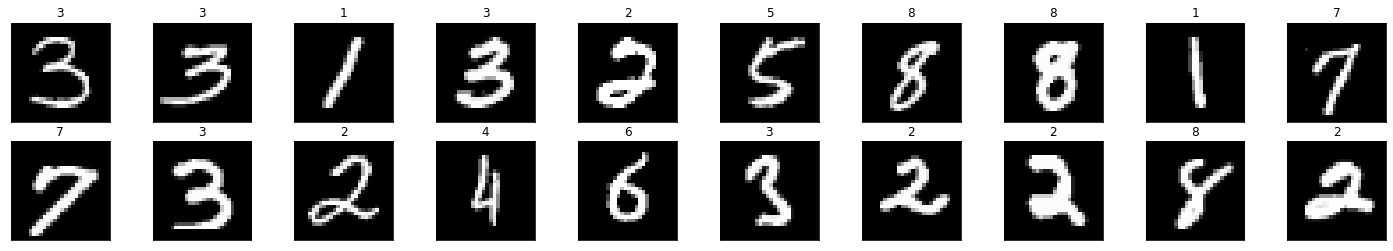

In [8]:
import matplotlib.pyplot as plt

data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images.numpy()
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    # //表示整除 /表示除法
    ax = fig.add_subplot(2, 20 // 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

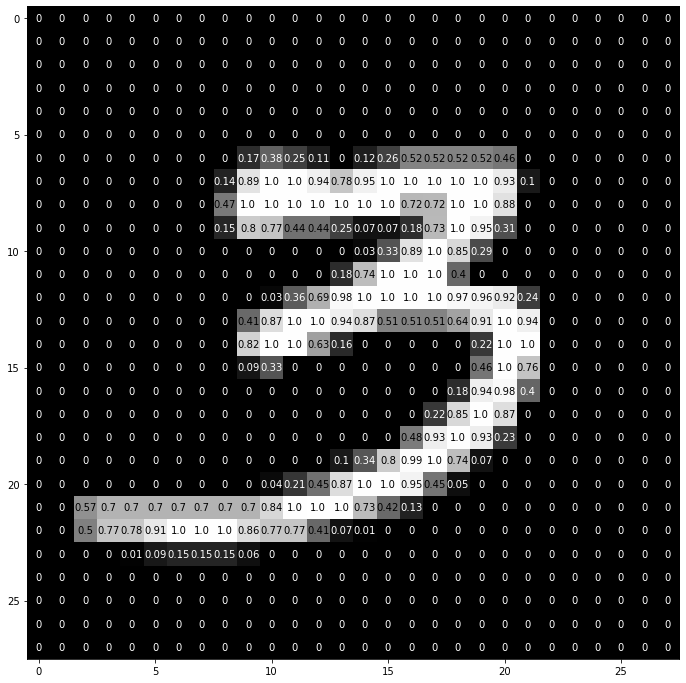

In [9]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network Architecture (30 marks)

* Input: a 784-dim Tensor of pixel values for each image.
* Output: a 10-dim Tensor of number of classes that indicates the class scores for an input image. 

You need to implement three models:
1. a vanilla multi-layer perceptron. (10 marks)
2. a multi-layer perceptron with regularization (dropout or L2 or both). (10 marks)
3. the corresponding loss functions and optimizers. (10 marks)

### Build model_1

In [52]:
# Define the MLP architecture
class VanillaMLP(nn.Module):
    def __init__(self):
        super(VanillaMLP, self).__init__()
        # implement your codes here
        self.linears = nn.Sequential(
            nn.Linear(28 * 28, 256),
            # 参数： inplace-选择是否进行覆盖运算,将得到的值计算得到的值覆盖之前的值
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # implement your codes here
        x = self.linears(x)
        x = F.softmax(x, dim=1)
        return x


# initialize the MLP
model_1 = VanillaMLP()

# specify loss function
# implement your codes here
loss_fn = F.cross_entropy

# specify your optimizer
# implement your codes here
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)

### Build model_2

In [48]:
# Define the MLP architecture
class RegularizedMLP(nn.Module):
    def __init__(self, d_prob=0.2):
        super(RegularizedMLP, self).__init__()
        # implement your codes here
        # 使用dropout正则化，让神经元随机失活
        self.linears = nn.Sequential(
            nn.Linear(28 * 28, 256),
            # 参数： inplace-选择是否进行覆盖运算,将得到的值计算得到的值覆盖之前的值
            nn.ReLU(inplace=True),
            nn.Dropout(d_prob),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(d_prob),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # implement your codes here
        x = self.linears(x)
        x = F.softmax(x, dim=1)
        return x


# initialize the MLP
model_2 = RegularizedMLP()

# specify loss function
# implement your codes here
loss_fn = F.cross_entropy

# specify your optimizer
# implement your codes here
learning_rate = 1e-4
# 使用L2正则化
l2 = 1e-4
optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate, weight_decay=l2)


---
## Train the Network (30 marks)

Train your models in the following two cells.

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

**The key parts in the training process are left for you to implement.**

### Train model_1

In [53]:
# number of epochs to train the model
n_epochs = 100  # suggest training between 100-150 epochs

model_1.train()  # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    total_correct = 0

    # for idx, (x, y) in enumerate(train_loader):
    for x, y in train_loader:
        # implement your code here
        out = model_1(x)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss  # the total loss of this batch
        _, pred = torch.max(out, 1)
        correct = pred.eq(y).sum().item()
        total_correct += correct  # the accumulated number of correctly classified samples of this batch

    # print training statistics
    # calculate average loss and accuracy over an epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100. * total_correct / len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Acc: {:.2f}%'.format(
        epoch + 1,
        train_loss,
        train_acc
    ))


Epoch: 1 	Training Loss: 0.108869 	Training Acc: 48.98%
Epoch: 2 	Training Loss: 0.091128 	Training Acc: 78.60%
Epoch: 3 	Training Loss: 0.084760 	Training Acc: 84.40%
Epoch: 4 	Training Loss: 0.082290 	Training Acc: 86.88%
Epoch: 5 	Training Loss: 0.080992 	Training Acc: 88.60%
Epoch: 6 	Training Loss: 0.080085 	Training Acc: 89.82%
Epoch: 7 	Training Loss: 0.079470 	Training Acc: 90.38%
Epoch: 8 	Training Loss: 0.078989 	Training Acc: 90.92%
Epoch: 9 	Training Loss: 0.078627 	Training Acc: 91.22%
Epoch: 10 	Training Loss: 0.078286 	Training Acc: 91.76%
Epoch: 11 	Training Loss: 0.078047 	Training Acc: 92.04%
Epoch: 12 	Training Loss: 0.077791 	Training Acc: 92.54%
Epoch: 13 	Training Loss: 0.077609 	Training Acc: 92.86%
Epoch: 14 	Training Loss: 0.077410 	Training Acc: 93.12%
Epoch: 15 	Training Loss: 0.077239 	Training Acc: 93.44%
Epoch: 16 	Training Loss: 0.077084 	Training Acc: 93.78%
Epoch: 17 	Training Loss: 0.076952 	Training Acc: 93.72%
Epoch: 18 	Training Loss: 0.076823 	Trai

### Train model_2

In [50]:
# number of epochs to train the model
n_epochs = 100  # suggest training between 100-150 epochs

model_2.train()  # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    total_correct = 0

    # for idx, (x, y) in enumerate(train_loader):
    for x, y in train_loader:
        # implement your code here
        out = model_2(x)
        loss = loss_fn(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss  # the total loss of this batch
        _, pred = torch.max(out, 1)
        correct = pred.eq(y).sum().item()
        total_correct += correct  # the accumulated number of correctly classified samples of this batch

    # print training statistics
    # calculate average loss and accuracy over an epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100. * total_correct / len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Acc: {:.2f}%'.format(
        epoch + 1,
        train_loss,
        train_acc
    ))

Epoch: 1 	Training Loss: 0.111065 	Training Acc: 43.24%
Epoch: 2 	Training Loss: 0.095211 	Training Acc: 69.26%
Epoch: 3 	Training Loss: 0.088136 	Training Acc: 79.14%
Epoch: 4 	Training Loss: 0.085089 	Training Acc: 81.96%
Epoch: 5 	Training Loss: 0.083475 	Training Acc: 84.22%
Epoch: 6 	Training Loss: 0.082416 	Training Acc: 85.88%
Epoch: 7 	Training Loss: 0.081585 	Training Acc: 86.50%
Epoch: 8 	Training Loss: 0.081040 	Training Acc: 87.32%
Epoch: 9 	Training Loss: 0.080738 	Training Acc: 87.38%
Epoch: 10 	Training Loss: 0.080163 	Training Acc: 88.56%
Epoch: 11 	Training Loss: 0.079796 	Training Acc: 89.12%
Epoch: 12 	Training Loss: 0.079400 	Training Acc: 89.80%
Epoch: 13 	Training Loss: 0.079467 	Training Acc: 89.28%
Epoch: 14 	Training Loss: 0.078956 	Training Acc: 90.22%
Epoch: 15 	Training Loss: 0.078796 	Training Acc: 90.50%
Epoch: 16 	Training Loss: 0.078652 	Training Acc: 90.94%
Epoch: 17 	Training Loss: 0.078271 	Training Acc: 91.46%
Epoch: 18 	Training Loss: 0.078264 	Trai

---
## Test the Trained Network (20 marks)

Test the performance of trained models on test data. Except the total test accuracy, you should calculate the accuracy for each class.

### Test model_1

In [54]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model_1.eval()  # prep model for *evaluation*

for x, y in test_loader:
    # implement your code here
    out = model_1(x)
    test_loss = loss_fn(out, y)
    _, pred = torch.max(out, 1)
    result = pred.eq(y)
    cursor = 0
    for label in y:
        if result[cursor]:
            # the list of number of correctly classified samples of each class of this batch. label is the index.
            class_correct[label] += 1
        # the list of total number of samples of each class of this batch. label is the index.
        class_total[label] += 1
        cursor += 1
    # calculate and print avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of class %d: %.2f%%' % (i, 100 * class_correct[i] / class_total[i]))
        else:
            print('Test Accuracy of class %d: N/A (no testing examples)' % (i))

    print('\nTest Accuracy (Overall): %.2f%%' % (100. * np.sum(class_correct) / np.sum(class_total)))

Test Loss: 0.000147

Test Accuracy of class 0: 100.00%
Test Accuracy of class 1: 100.00%
Test Accuracy of class 2: 100.00%
Test Accuracy of class 3: 100.00%
Test Accuracy of class 4: 100.00%
Test Accuracy of class 5: N/A (no testing examples)
Test Accuracy of class 6: 100.00%
Test Accuracy of class 7: 100.00%
Test Accuracy of class 8: 100.00%
Test Accuracy of class 9: 100.00%

Test Accuracy (Overall): 100.00%
Test Loss: 0.000155

Test Accuracy of class 0: 100.00%
Test Accuracy of class 1: 100.00%
Test Accuracy of class 2: 100.00%
Test Accuracy of class 3: 75.00%
Test Accuracy of class 4: 100.00%
Test Accuracy of class 5: 66.67%
Test Accuracy of class 6: 100.00%
Test Accuracy of class 7: 100.00%
Test Accuracy of class 8: 100.00%
Test Accuracy of class 9: 100.00%

Test Accuracy (Overall): 95.00%
Test Loss: 0.000151

Test Accuracy of class 0: 100.00%
Test Accuracy of class 1: 100.00%
Test Accuracy of class 2: 100.00%
Test Accuracy of class 3: 83.33%
Test Accuracy of class 4: 100.00%
Test 

Test Loss: 0.000157

Test Accuracy of class 0: 100.00%
Test Accuracy of class 1: 94.05%
Test Accuracy of class 2: 94.59%
Test Accuracy of class 3: 91.80%
Test Accuracy of class 4: 96.88%
Test Accuracy of class 5: 96.23%
Test Accuracy of class 6: 100.00%
Test Accuracy of class 7: 97.33%
Test Accuracy of class 8: 84.00%
Test Accuracy of class 9: 90.14%

Test Accuracy (Overall): 94.26%
Test Loss: 0.000156

Test Accuracy of class 0: 100.00%
Test Accuracy of class 1: 94.19%
Test Accuracy of class 2: 94.81%
Test Accuracy of class 3: 92.19%
Test Accuracy of class 4: 95.38%
Test Accuracy of class 5: 96.36%
Test Accuracy of class 6: 100.00%
Test Accuracy of class 7: 97.44%
Test Accuracy of class 8: 84.21%
Test Accuracy of class 9: 89.04%

Test Accuracy (Overall): 94.14%
Test Loss: 0.000162

Test Accuracy of class 0: 100.00%
Test Accuracy of class 1: 94.38%
Test Accuracy of class 2: 95.06%
Test Accuracy of class 3: 92.54%
Test Accuracy of class 4: 95.45%
Test Accuracy of class 5: 96.43%
Test Acc

Test Loss: 0.000153

Test Accuracy of class 0: 98.80%
Test Accuracy of class 1: 95.29%
Test Accuracy of class 2: 92.31%
Test Accuracy of class 3: 90.51%
Test Accuracy of class 4: 93.71%
Test Accuracy of class 5: 88.89%
Test Accuracy of class 6: 94.19%
Test Accuracy of class 7: 95.06%
Test Accuracy of class 8: 85.92%
Test Accuracy of class 9: 90.26%

Test Accuracy (Overall): 92.73%
Test Loss: 0.000149

Test Accuracy of class 0: 98.80%
Test Accuracy of class 1: 95.35%
Test Accuracy of class 2: 92.31%
Test Accuracy of class 3: 90.78%
Test Accuracy of class 4: 93.87%
Test Accuracy of class 5: 88.28%
Test Accuracy of class 6: 94.27%
Test Accuracy of class 7: 95.06%
Test Accuracy of class 8: 86.11%
Test Accuracy of class 9: 90.45%

Test Accuracy (Overall): 92.76%
Test Loss: 0.000152

Test Accuracy of class 0: 98.83%
Test Accuracy of class 1: 95.35%
Test Accuracy of class 2: 92.44%
Test Accuracy of class 3: 91.03%
Test Accuracy of class 4: 93.98%
Test Accuracy of class 5: 88.55%
Test Accuracy

Test Loss: 0.000153

Test Accuracy of class 0: 97.95%
Test Accuracy of class 1: 96.77%
Test Accuracy of class 2: 88.76%
Test Accuracy of class 3: 90.83%
Test Accuracy of class 4: 93.20%
Test Accuracy of class 5: 90.00%
Test Accuracy of class 6: 93.99%
Test Accuracy of class 7: 93.75%
Test Accuracy of class 8: 89.04%
Test Accuracy of class 9: 90.61%

Test Accuracy (Overall): 92.62%
Test Loss: 0.000154

Test Accuracy of class 0: 97.96%
Test Accuracy of class 1: 96.80%
Test Accuracy of class 2: 88.80%
Test Accuracy of class 3: 90.91%
Test Accuracy of class 4: 92.89%
Test Accuracy of class 5: 90.10%
Test Accuracy of class 6: 94.04%
Test Accuracy of class 7: 93.77%
Test Accuracy of class 8: 89.24%
Test Accuracy of class 9: 90.69%

Test Accuracy (Overall): 92.64%
Test Loss: 0.000153

Test Accuracy of class 0: 97.98%
Test Accuracy of class 1: 96.80%
Test Accuracy of class 2: 88.85%
Test Accuracy of class 3: 91.02%
Test Accuracy of class 4: 92.25%
Test Accuracy of class 5: 90.15%
Test Accuracy

Test Loss: 0.000149

Test Accuracy of class 0: 97.83%
Test Accuracy of class 1: 97.38%
Test Accuracy of class 2: 89.24%
Test Accuracy of class 3: 91.74%
Test Accuracy of class 4: 93.45%
Test Accuracy of class 5: 89.96%
Test Accuracy of class 6: 93.77%
Test Accuracy of class 7: 93.00%
Test Accuracy of class 8: 90.42%
Test Accuracy of class 9: 91.15%

Test Accuracy (Overall): 92.89%
Test Loss: 0.000155

Test Accuracy of class 0: 97.83%
Test Accuracy of class 1: 96.88%
Test Accuracy of class 2: 89.31%
Test Accuracy of class 3: 91.79%
Test Accuracy of class 4: 93.47%
Test Accuracy of class 5: 90.07%
Test Accuracy of class 6: 93.79%
Test Accuracy of class 7: 93.02%
Test Accuracy of class 8: 90.51%
Test Accuracy of class 9: 91.23%

Test Accuracy (Overall): 92.87%
Test Loss: 0.000157

Test Accuracy of class 0: 97.85%
Test Accuracy of class 1: 96.89%
Test Accuracy of class 2: 89.37%
Test Accuracy of class 3: 91.87%
Test Accuracy of class 4: 93.49%
Test Accuracy of class 5: 89.75%
Test Accuracy

Test Loss: 0.000148

Test Accuracy of class 0: 98.26%
Test Accuracy of class 1: 97.06%
Test Accuracy of class 2: 89.93%
Test Accuracy of class 3: 91.58%
Test Accuracy of class 4: 91.90%
Test Accuracy of class 5: 89.04%
Test Accuracy of class 6: 94.75%
Test Accuracy of class 7: 91.31%
Test Accuracy of class 8: 91.32%
Test Accuracy of class 9: 91.97%

Test Accuracy (Overall): 92.79%
Test Loss: 0.000163

Test Accuracy of class 0: 98.26%
Test Accuracy of class 1: 97.07%
Test Accuracy of class 2: 90.02%
Test Accuracy of class 3: 91.60%
Test Accuracy of class 4: 91.94%
Test Accuracy of class 5: 89.04%
Test Accuracy of class 6: 94.80%
Test Accuracy of class 7: 91.15%
Test Accuracy of class 8: 91.34%
Test Accuracy of class 9: 91.55%

Test Accuracy (Overall): 92.75%
Test Loss: 0.000156

Test Accuracy of class 0: 98.26%
Test Accuracy of class 1: 97.07%
Test Accuracy of class 2: 90.04%
Test Accuracy of class 3: 91.44%
Test Accuracy of class 4: 91.99%
Test Accuracy of class 5: 88.80%
Test Accuracy

Test Loss: 0.000153

Test Accuracy of class 0: 98.35%
Test Accuracy of class 1: 96.50%
Test Accuracy of class 2: 90.00%
Test Accuracy of class 3: 91.42%
Test Accuracy of class 4: 92.42%
Test Accuracy of class 5: 87.77%
Test Accuracy of class 6: 94.37%
Test Accuracy of class 7: 91.01%
Test Accuracy of class 8: 91.48%
Test Accuracy of class 9: 91.36%

Test Accuracy (Overall): 92.58%
Test Loss: 0.000154

Test Accuracy of class 0: 98.36%
Test Accuracy of class 1: 96.52%
Test Accuracy of class 2: 90.06%
Test Accuracy of class 3: 91.44%
Test Accuracy of class 4: 92.43%
Test Accuracy of class 5: 87.59%
Test Accuracy of class 6: 94.40%
Test Accuracy of class 7: 91.06%
Test Accuracy of class 8: 91.51%
Test Accuracy of class 9: 91.38%

Test Accuracy (Overall): 92.59%
Test Loss: 0.000152

Test Accuracy of class 0: 98.36%
Test Accuracy of class 1: 96.52%
Test Accuracy of class 2: 90.06%
Test Accuracy of class 3: 91.29%
Test Accuracy of class 4: 92.48%
Test Accuracy of class 5: 87.62%
Test Accuracy

Test Loss: 0.000146

Test Accuracy of class 0: 98.43%
Test Accuracy of class 1: 96.88%
Test Accuracy of class 2: 90.03%
Test Accuracy of class 3: 91.53%
Test Accuracy of class 4: 91.91%
Test Accuracy of class 5: 86.97%
Test Accuracy of class 6: 94.27%
Test Accuracy of class 7: 91.27%
Test Accuracy of class 8: 91.64%
Test Accuracy of class 9: 91.85%

Test Accuracy (Overall): 92.61%
Test Loss: 0.000158

Test Accuracy of class 0: 98.27%
Test Accuracy of class 1: 96.89%
Test Accuracy of class 2: 90.08%
Test Accuracy of class 3: 91.53%
Test Accuracy of class 4: 91.94%
Test Accuracy of class 5: 87.03%
Test Accuracy of class 6: 94.28%
Test Accuracy of class 7: 91.30%
Test Accuracy of class 8: 91.65%
Test Accuracy of class 9: 91.75%

Test Accuracy (Overall): 92.60%
Test Loss: 0.000147

Test Accuracy of class 0: 98.27%
Test Accuracy of class 1: 96.90%
Test Accuracy of class 2: 90.15%
Test Accuracy of class 3: 91.55%
Test Accuracy of class 4: 91.97%
Test Accuracy of class 5: 87.08%
Test Accuracy

Test Loss: 0.000151

Test Accuracy of class 0: 98.22%
Test Accuracy of class 1: 97.17%
Test Accuracy of class 2: 90.14%
Test Accuracy of class 3: 91.13%
Test Accuracy of class 4: 91.65%
Test Accuracy of class 5: 87.67%
Test Accuracy of class 6: 94.38%
Test Accuracy of class 7: 91.29%
Test Accuracy of class 8: 91.39%
Test Accuracy of class 9: 91.59%

Test Accuracy (Overall): 92.59%
Test Loss: 0.000147

Test Accuracy of class 0: 98.23%
Test Accuracy of class 1: 97.17%
Test Accuracy of class 2: 90.18%
Test Accuracy of class 3: 91.18%
Test Accuracy of class 4: 91.67%
Test Accuracy of class 5: 87.71%
Test Accuracy of class 6: 94.40%
Test Accuracy of class 7: 91.30%
Test Accuracy of class 8: 91.40%
Test Accuracy of class 9: 91.62%

Test Accuracy (Overall): 92.61%
Test Loss: 0.000164

Test Accuracy of class 0: 98.24%
Test Accuracy of class 1: 97.17%
Test Accuracy of class 2: 89.94%
Test Accuracy of class 3: 91.06%
Test Accuracy of class 4: 91.69%
Test Accuracy of class 5: 87.76%
Test Accuracy

Test Loss: 0.000151

Test Accuracy of class 0: 97.55%
Test Accuracy of class 1: 97.05%
Test Accuracy of class 2: 90.02%
Test Accuracy of class 3: 90.38%
Test Accuracy of class 4: 91.87%
Test Accuracy of class 5: 87.76%
Test Accuracy of class 6: 94.53%
Test Accuracy of class 7: 91.79%
Test Accuracy of class 8: 91.34%
Test Accuracy of class 9: 91.47%

Test Accuracy (Overall): 92.50%
Test Loss: 0.000157

Test Accuracy of class 0: 97.56%
Test Accuracy of class 1: 97.07%
Test Accuracy of class 2: 90.05%
Test Accuracy of class 3: 90.41%
Test Accuracy of class 4: 91.88%
Test Accuracy of class 5: 87.78%
Test Accuracy of class 6: 94.53%
Test Accuracy of class 7: 91.71%
Test Accuracy of class 8: 91.36%
Test Accuracy of class 9: 91.35%

Test Accuracy (Overall): 92.49%
Test Loss: 0.000147

Test Accuracy of class 0: 97.57%
Test Accuracy of class 1: 97.08%
Test Accuracy of class 2: 90.10%
Test Accuracy of class 3: 90.42%
Test Accuracy of class 4: 91.88%
Test Accuracy of class 5: 87.78%
Test Accuracy

Test Loss: 0.000152

Test Accuracy of class 0: 97.78%
Test Accuracy of class 1: 97.14%
Test Accuracy of class 2: 89.81%
Test Accuracy of class 3: 89.99%
Test Accuracy of class 4: 91.56%
Test Accuracy of class 5: 88.21%
Test Accuracy of class 6: 94.64%
Test Accuracy of class 7: 91.94%
Test Accuracy of class 8: 91.75%
Test Accuracy of class 9: 91.72%

Test Accuracy (Overall): 92.55%
Test Loss: 0.000151

Test Accuracy of class 0: 97.78%
Test Accuracy of class 1: 97.15%
Test Accuracy of class 2: 89.82%
Test Accuracy of class 3: 90.01%
Test Accuracy of class 4: 91.58%
Test Accuracy of class 5: 88.14%
Test Accuracy of class 6: 94.66%
Test Accuracy of class 7: 91.95%
Test Accuracy of class 8: 91.77%
Test Accuracy of class 9: 91.75%

Test Accuracy (Overall): 92.56%
Test Loss: 0.000151

Test Accuracy of class 0: 97.79%
Test Accuracy of class 1: 97.16%
Test Accuracy of class 2: 89.85%
Test Accuracy of class 3: 90.06%
Test Accuracy of class 4: 91.59%
Test Accuracy of class 5: 88.06%
Test Accuracy

Test Loss: 0.000153

Test Accuracy of class 0: 97.75%
Test Accuracy of class 1: 97.21%
Test Accuracy of class 2: 89.99%
Test Accuracy of class 3: 90.15%
Test Accuracy of class 4: 91.71%
Test Accuracy of class 5: 87.90%
Test Accuracy of class 6: 94.53%
Test Accuracy of class 7: 92.16%
Test Accuracy of class 8: 91.64%
Test Accuracy of class 9: 92.08%

Test Accuracy (Overall): 92.60%
Test Loss: 0.000151

Test Accuracy of class 0: 97.76%
Test Accuracy of class 1: 97.22%
Test Accuracy of class 2: 90.03%
Test Accuracy of class 3: 90.17%
Test Accuracy of class 4: 91.72%
Test Accuracy of class 5: 87.90%
Test Accuracy of class 6: 94.53%
Test Accuracy of class 7: 92.19%
Test Accuracy of class 8: 91.68%
Test Accuracy of class 9: 92.08%

Test Accuracy (Overall): 92.62%
Test Loss: 0.000161

Test Accuracy of class 0: 97.76%
Test Accuracy of class 1: 97.22%
Test Accuracy of class 2: 90.03%
Test Accuracy of class 3: 90.17%
Test Accuracy of class 4: 91.54%
Test Accuracy of class 5: 87.84%
Test Accuracy

### Test model_2

In [51]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model_2.eval()  # prep model for *evaluation*

for x, y in test_loader:
    # implement your code here
    out = model_2(x)
    test_loss = loss_fn(out, y)
    _, pred = torch.max(out, 1)
    result = pred.eq(y)
    cursor = 0
    for label in y:
        if result[cursor]:
            # the list of number of correctly classified samples of each class of this batch. label is the index.
            class_correct[label] += 1
        # the list of total number of samples of each class of this batch. label is the index.
        class_total[label] += 1
        cursor += 1
    # calculate and print avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of class %d: %.2f%%' % (i, 100 * class_correct[i] / class_total[i]))
        else:
            print('Test Accuracy of class %d: N/A (no training examples)' % (i))

    print('\nTest Accuracy (Overall): %.2f%%' % (100. * np.sum(class_correct) / np.sum(class_total)))

Test Loss: 0.000148

Test Accuracy of class 0: 100.00%
Test Accuracy of class 1: 100.00%
Test Accuracy of class 2: 100.00%
Test Accuracy of class 3: 100.00%
Test Accuracy of class 4: 100.00%
Test Accuracy of class 5: 100.00%
Test Accuracy of class 6: 100.00%
Test Accuracy of class 7: 100.00%
Test Accuracy of class 8: 100.00%
Test Accuracy of class 9: N/A (no training examples)

Test Accuracy (Overall): 100.00%
Test Loss: 0.000146

Test Accuracy of class 0: 100.00%
Test Accuracy of class 1: 100.00%
Test Accuracy of class 2: 100.00%
Test Accuracy of class 3: 100.00%
Test Accuracy of class 4: 100.00%
Test Accuracy of class 5: 100.00%
Test Accuracy of class 6: 100.00%
Test Accuracy of class 7: 100.00%
Test Accuracy of class 8: 100.00%
Test Accuracy of class 9: 100.00%

Test Accuracy (Overall): 100.00%
Test Loss: 0.000149

Test Accuracy of class 0: 100.00%
Test Accuracy of class 1: 100.00%
Test Accuracy of class 2: 100.00%
Test Accuracy of class 3: 100.00%
Test Accuracy of class 4: 83.33%
T

Test Loss: 0.000151

Test Accuracy of class 0: 98.89%
Test Accuracy of class 1: 100.00%
Test Accuracy of class 2: 92.31%
Test Accuracy of class 3: 92.13%
Test Accuracy of class 4: 96.10%
Test Accuracy of class 5: 87.84%
Test Accuracy of class 6: 92.68%
Test Accuracy of class 7: 96.92%
Test Accuracy of class 8: 88.41%
Test Accuracy of class 9: 93.83%

Test Accuracy (Overall): 94.12%
Test Loss: 0.000152

Test Accuracy of class 0: 98.90%
Test Accuracy of class 1: 100.00%
Test Accuracy of class 2: 92.59%
Test Accuracy of class 3: 92.31%
Test Accuracy of class 4: 96.20%
Test Accuracy of class 5: 88.46%
Test Accuracy of class 6: 92.77%
Test Accuracy of class 7: 96.92%
Test Accuracy of class 8: 88.57%
Test Accuracy of class 9: 94.12%

Test Accuracy (Overall): 94.27%
Test Loss: 0.000146

Test Accuracy of class 0: 98.91%
Test Accuracy of class 1: 100.00%
Test Accuracy of class 2: 92.68%
Test Accuracy of class 3: 92.55%
Test Accuracy of class 4: 96.25%
Test Accuracy of class 5: 88.89%
Test Accur

Test Loss: 0.000148

Test Accuracy of class 0: 98.86%
Test Accuracy of class 1: 97.86%
Test Accuracy of class 2: 94.92%
Test Accuracy of class 3: 91.72%
Test Accuracy of class 4: 95.00%
Test Accuracy of class 5: 91.67%
Test Accuracy of class 6: 92.31%
Test Accuracy of class 7: 95.86%
Test Accuracy of class 8: 91.77%
Test Accuracy of class 9: 91.43%

Test Accuracy (Overall): 94.23%
Test Loss: 0.000151

Test Accuracy of class 0: 98.88%
Test Accuracy of class 1: 97.88%
Test Accuracy of class 2: 95.00%
Test Accuracy of class 3: 91.76%
Test Accuracy of class 4: 95.03%
Test Accuracy of class 5: 91.16%
Test Accuracy of class 6: 92.40%
Test Accuracy of class 7: 95.92%
Test Accuracy of class 8: 91.88%
Test Accuracy of class 9: 91.48%

Test Accuracy (Overall): 94.24%
Test Loss: 0.000151

Test Accuracy of class 0: 98.88%
Test Accuracy of class 1: 97.88%
Test Accuracy of class 2: 95.08%
Test Accuracy of class 3: 91.33%
Test Accuracy of class 4: 95.05%
Test Accuracy of class 5: 91.16%
Test Accuracy

Test Loss: 0.000154

Test Accuracy of class 0: 98.87%
Test Accuracy of class 1: 98.58%
Test Accuracy of class 2: 93.82%
Test Accuracy of class 3: 92.31%
Test Accuracy of class 4: 95.10%
Test Accuracy of class 5: 91.16%
Test Accuracy of class 6: 93.46%
Test Accuracy of class 7: 96.69%
Test Accuracy of class 8: 93.31%
Test Accuracy of class 9: 92.61%

Test Accuracy (Overall): 94.69%
Test Loss: 0.000152

Test Accuracy of class 0: 98.87%
Test Accuracy of class 1: 98.59%
Test Accuracy of class 2: 93.82%
Test Accuracy of class 3: 92.34%
Test Accuracy of class 4: 95.10%
Test Accuracy of class 5: 90.78%
Test Accuracy of class 6: 93.54%
Test Accuracy of class 7: 96.75%
Test Accuracy of class 8: 93.42%
Test Accuracy of class 9: 92.69%

Test Accuracy (Overall): 94.69%
Test Loss: 0.000146

Test Accuracy of class 0: 98.88%
Test Accuracy of class 1: 98.60%
Test Accuracy of class 2: 93.82%
Test Accuracy of class 3: 92.40%
Test Accuracy of class 4: 95.17%
Test Accuracy of class 5: 90.83%
Test Accuracy

Test Loss: 0.000148

Test Accuracy of class 0: 98.88%
Test Accuracy of class 1: 98.41%
Test Accuracy of class 2: 93.85%
Test Accuracy of class 3: 93.04%
Test Accuracy of class 4: 94.92%
Test Accuracy of class 5: 91.10%
Test Accuracy of class 6: 94.12%
Test Accuracy of class 7: 96.30%
Test Accuracy of class 8: 94.43%
Test Accuracy of class 9: 92.67%

Test Accuracy (Overall): 94.88%
Test Loss: 0.000154

Test Accuracy of class 0: 98.88%
Test Accuracy of class 1: 98.43%
Test Accuracy of class 2: 93.85%
Test Accuracy of class 3: 93.10%
Test Accuracy of class 4: 94.93%
Test Accuracy of class 5: 91.20%
Test Accuracy of class 6: 94.12%
Test Accuracy of class 7: 96.33%
Test Accuracy of class 8: 94.19%
Test Accuracy of class 9: 92.67%

Test Accuracy (Overall): 94.88%
Test Loss: 0.000152

Test Accuracy of class 0: 98.89%
Test Accuracy of class 1: 98.43%
Test Accuracy of class 2: 93.92%
Test Accuracy of class 3: 93.14%
Test Accuracy of class 4: 94.96%
Test Accuracy of class 5: 91.26%
Test Accuracy

Test Loss: 0.000146

Test Accuracy of class 0: 98.43%
Test Accuracy of class 1: 97.96%
Test Accuracy of class 2: 94.44%
Test Accuracy of class 3: 92.06%
Test Accuracy of class 4: 94.63%
Test Accuracy of class 5: 91.84%
Test Accuracy of class 6: 94.72%
Test Accuracy of class 7: 95.97%
Test Accuracy of class 8: 93.56%
Test Accuracy of class 9: 92.72%

Test Accuracy (Overall): 94.72%
Test Loss: 0.000146

Test Accuracy of class 0: 98.45%
Test Accuracy of class 1: 97.97%
Test Accuracy of class 2: 94.46%
Test Accuracy of class 3: 92.08%
Test Accuracy of class 4: 94.63%
Test Accuracy of class 5: 91.88%
Test Accuracy of class 6: 94.76%
Test Accuracy of class 7: 96.00%
Test Accuracy of class 8: 93.57%
Test Accuracy of class 9: 92.76%

Test Accuracy (Overall): 94.75%
Test Loss: 0.000157

Test Accuracy of class 0: 98.45%
Test Accuracy of class 1: 97.98%
Test Accuracy of class 2: 94.25%
Test Accuracy of class 3: 92.12%
Test Accuracy of class 4: 94.66%
Test Accuracy of class 5: 91.93%
Test Accuracy

Test Loss: 0.000151

Test Accuracy of class 0: 98.20%
Test Accuracy of class 1: 97.99%
Test Accuracy of class 2: 94.56%
Test Accuracy of class 3: 92.09%
Test Accuracy of class 4: 94.85%
Test Accuracy of class 5: 92.02%
Test Accuracy of class 6: 94.58%
Test Accuracy of class 7: 96.10%
Test Accuracy of class 8: 92.91%
Test Accuracy of class 9: 92.66%

Test Accuracy (Overall): 94.69%
Test Loss: 0.000151

Test Accuracy of class 0: 98.20%
Test Accuracy of class 1: 98.01%
Test Accuracy of class 2: 94.58%
Test Accuracy of class 3: 92.16%
Test Accuracy of class 4: 94.86%
Test Accuracy of class 5: 91.86%
Test Accuracy of class 6: 94.58%
Test Accuracy of class 7: 96.12%
Test Accuracy of class 8: 92.93%
Test Accuracy of class 9: 92.66%

Test Accuracy (Overall): 94.70%
Test Loss: 0.000151

Test Accuracy of class 0: 98.21%
Test Accuracy of class 1: 98.01%
Test Accuracy of class 2: 94.59%
Test Accuracy of class 3: 92.21%
Test Accuracy of class 4: 94.88%
Test Accuracy of class 5: 91.88%
Test Accuracy

Test Loss: 0.000147

Test Accuracy of class 0: 97.82%
Test Accuracy of class 1: 98.17%
Test Accuracy of class 2: 94.40%
Test Accuracy of class 3: 92.42%
Test Accuracy of class 4: 95.18%
Test Accuracy of class 5: 92.31%
Test Accuracy of class 6: 94.88%
Test Accuracy of class 7: 95.47%
Test Accuracy of class 8: 92.93%
Test Accuracy of class 9: 93.11%

Test Accuracy (Overall): 94.76%
Test Loss: 0.000153

Test Accuracy of class 0: 97.83%
Test Accuracy of class 1: 98.17%
Test Accuracy of class 2: 94.25%
Test Accuracy of class 3: 92.43%
Test Accuracy of class 4: 95.19%
Test Accuracy of class 5: 92.34%
Test Accuracy of class 6: 94.89%
Test Accuracy of class 7: 95.48%
Test Accuracy of class 8: 92.94%
Test Accuracy of class 9: 93.17%

Test Accuracy (Overall): 94.76%
Test Loss: 0.000150

Test Accuracy of class 0: 97.83%
Test Accuracy of class 1: 98.18%
Test Accuracy of class 2: 94.11%
Test Accuracy of class 3: 92.44%
Test Accuracy of class 4: 95.21%
Test Accuracy of class 5: 92.36%
Test Accuracy

Test Loss: 0.000150

Test Accuracy of class 0: 97.15%
Test Accuracy of class 1: 98.02%
Test Accuracy of class 2: 94.13%
Test Accuracy of class 3: 92.87%
Test Accuracy of class 4: 94.43%
Test Accuracy of class 5: 92.31%
Test Accuracy of class 6: 95.11%
Test Accuracy of class 7: 95.53%
Test Accuracy of class 8: 92.33%
Test Accuracy of class 9: 93.36%

Test Accuracy (Overall): 94.60%
Test Loss: 0.000151

Test Accuracy of class 0: 97.15%
Test Accuracy of class 1: 98.04%
Test Accuracy of class 2: 94.15%
Test Accuracy of class 3: 92.88%
Test Accuracy of class 4: 94.44%
Test Accuracy of class 5: 92.32%
Test Accuracy of class 6: 94.99%
Test Accuracy of class 7: 95.53%
Test Accuracy of class 8: 92.37%
Test Accuracy of class 9: 93.37%

Test Accuracy (Overall): 94.60%
Test Loss: 0.000148

Test Accuracy of class 0: 97.16%
Test Accuracy of class 1: 98.04%
Test Accuracy of class 2: 94.17%
Test Accuracy of class 3: 92.89%
Test Accuracy of class 4: 94.48%
Test Accuracy of class 5: 92.35%
Test Accuracy

Test Loss: 0.000148

Test Accuracy of class 0: 97.51%
Test Accuracy of class 1: 98.18%
Test Accuracy of class 2: 93.68%
Test Accuracy of class 3: 92.81%
Test Accuracy of class 4: 94.81%
Test Accuracy of class 5: 92.55%
Test Accuracy of class 6: 95.26%
Test Accuracy of class 7: 95.58%
Test Accuracy of class 8: 92.62%
Test Accuracy of class 9: 93.10%

Test Accuracy (Overall): 94.69%
Test Loss: 0.000146

Test Accuracy of class 0: 97.52%
Test Accuracy of class 1: 98.19%
Test Accuracy of class 2: 93.69%
Test Accuracy of class 3: 92.83%
Test Accuracy of class 4: 94.81%
Test Accuracy of class 5: 92.56%
Test Accuracy of class 6: 95.27%
Test Accuracy of class 7: 95.59%
Test Accuracy of class 8: 92.62%
Test Accuracy of class 9: 93.14%

Test Accuracy (Overall): 94.70%
Test Loss: 0.000154

Test Accuracy of class 0: 97.53%
Test Accuracy of class 1: 98.09%
Test Accuracy of class 2: 93.72%
Test Accuracy of class 3: 92.84%
Test Accuracy of class 4: 94.71%
Test Accuracy of class 5: 92.60%
Test Accuracy

Test Loss: 0.000147

Test Accuracy of class 0: 97.29%
Test Accuracy of class 1: 98.16%
Test Accuracy of class 2: 93.25%
Test Accuracy of class 3: 92.87%
Test Accuracy of class 4: 94.88%
Test Accuracy of class 5: 91.99%
Test Accuracy of class 6: 95.49%
Test Accuracy of class 7: 94.82%
Test Accuracy of class 8: 92.26%
Test Accuracy of class 9: 93.04%

Test Accuracy (Overall): 94.48%
Test Loss: 0.000152

Test Accuracy of class 0: 97.29%
Test Accuracy of class 1: 98.16%
Test Accuracy of class 2: 93.28%
Test Accuracy of class 3: 92.89%
Test Accuracy of class 4: 94.89%
Test Accuracy of class 5: 92.00%
Test Accuracy of class 6: 95.49%
Test Accuracy of class 7: 94.83%
Test Accuracy of class 8: 92.29%
Test Accuracy of class 9: 93.07%

Test Accuracy (Overall): 94.49%
Test Loss: 0.000153

Test Accuracy of class 0: 97.29%
Test Accuracy of class 1: 98.16%
Test Accuracy of class 2: 93.33%
Test Accuracy of class 3: 92.79%
Test Accuracy of class 4: 94.90%
Test Accuracy of class 5: 92.01%
Test Accuracy

---
## Analyze Your Result (20 marks)
Compare the performance of your models with the following analysis. Both English and Chinese answers are acceptable.
1. Does your vanilla MLP overfit to the training data? (5 marks)

Answer:

2. If yes, how do you observe it? If no, why? (5 marks)

Answer:

3. Is regularized model help prevent overfitting? (5 marks)

Answer:

4. Generally compare the performance of two models. (5 marks)

Answer:


第一题解答：
在vanilla MLP model中，我认为没有显著的过拟合出现，或者表达为过拟合程度较小。

第二题解答：
在vanilla MLP model中，经过100个epoch的训练，我们模型在训练集上的水平：
Epoch: 100 	Training Loss: 0.074206 	Training Acc: 97.74%
在测试集上的平均水平：
Test Accuracy (Overall): 92.62%
在这里虽然测试集的精度比训练集的精度低，但是有可能是因为测试集的数据分布和训练集略有区别导致，
并且有可能是因为模型较简单，模型表达能力不足的原因。
另外一方面，我们梯度下降的步长设置为1e-4，也降低了过拟合风险。
所以我认为虽然在这里虽然测试集的精度比训练集的精度有所下降，但是并没有显著过拟合。
但若是对比model_2的regularized model，我们发现同样的模型引入正则化后有效果提升，所以可能也存在较小的过拟合。

第三题解答：
在model_2的regularized model中，我们引入了L2正则化和Dropout正则化两种正则化手段，我认为regularized model有利于防止过拟合。
从训练效果上看，经过100个epoch的训练，我们模型在训练集上的水平：
Epoch: 100 	Training Loss: 0.074179 	Training Acc: 98.30%
可以看到在loss相近的情况下，模型的准确度相对于vanilla MLP model有所提升。
同时，对比测试结果：
Test Accuracy (Overall): 94.46%
在这里测试结果也相对于vanilla MLP model有所提升，说明正则化确实提升了模型效果，降低了过拟合风险。


第四题解答：
在vanilla MLP model中，我们没有引入正则化项，在model_2的regularized model中，我们引入了L2正则化和Dropout正则化两种正则化手段。
通过观察前10个epoch的训练过程：
model_1:
Epoch: 1 	Training Loss: 0.108869 	Training Acc: 48.98%
Epoch: 2 	Training Loss: 0.091128 	Training Acc: 78.60%
Epoch: 3 	Training Loss: 0.084760 	Training Acc: 84.40%
Epoch: 4 	Training Loss: 0.082290 	Training Acc: 86.88%
Epoch: 5 	Training Loss: 0.080992 	Training Acc: 88.60%
Epoch: 6 	Training Loss: 0.080085 	Training Acc: 89.82%
Epoch: 7 	Training Loss: 0.079470 	Training Acc: 90.38%
Epoch: 8 	Training Loss: 0.078989 	Training Acc: 90.92%
Epoch: 9 	Training Loss: 0.078627 	Training Acc: 91.22%
Epoch: 10 	Training Loss: 0.078286 	Training Acc: 91.76%
......
Epoch: 95 	Training Loss: 0.074192 	Training Acc: 97.76%
Epoch: 96 	Training Loss: 0.074181 	Training Acc: 97.76%
Epoch: 97 	Training Loss: 0.074176 	Training Acc: 97.76%
Epoch: 98 	Training Loss: 0.074177 	Training Acc: 97.76%
Epoch: 99 	Training Loss: 0.074174 	Training Acc: 97.76%
Epoch: 100 	Training Loss: 0.074206 	Training Acc: 97.74%
model_2:
Epoch: 1 	Training Loss: 0.111065 	Training Acc: 43.24%
Epoch: 2 	Training Loss: 0.095211 	Training Acc: 69.26%
Epoch: 3 	Training Loss: 0.088136 	Training Acc: 79.14%
Epoch: 4 	Training Loss: 0.085089 	Training Acc: 81.96%
Epoch: 5 	Training Loss: 0.083475 	Training Acc: 84.22%
Epoch: 6 	Training Loss: 0.082416 	Training Acc: 85.88%
Epoch: 7 	Training Loss: 0.081585 	Training Acc: 86.50%
Epoch: 8 	Training Loss: 0.081040 	Training Acc: 87.32%
Epoch: 9 	Training Loss: 0.080738 	Training Acc: 87.38%
Epoch: 10 	Training Loss: 0.080163 	Training Acc: 88.56%
......
Epoch: 95 	Training Loss: 0.074259 	Training Acc: 98.10%
Epoch: 96 	Training Loss: 0.074258 	Training Acc: 98.16%
Epoch: 97 	Training Loss: 0.074221 	Training Acc: 98.24%
Epoch: 98 	Training Loss: 0.074187 	Training Acc: 98.30%
Epoch: 99 	Training Loss: 0.074161 	Training Acc: 98.32%
Epoch: 100 	Training Loss: 0.074179 	Training Acc: 98.30%
我们可以看到，引入正则化的模型在模型的收敛速度上相对于没有引入正则化的模型收敛速度较慢，
但在最终的效果上，引入正则化的模型要更加出色，因为有起到降低过拟合的效果。
所以在测试集上，引入正则化的模型的结果明显取得了更好的结果。